# 00 - Getting Started with `evosax` - The Ask-Eval-Tell API
### [Last Update: February 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/00_getting_started.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Evolution Strategy Instantiation

In [2]:
import jax
import jax.numpy as jnp
from evosax import CMA_ES
from evosax.problems import ClassicFitness

# Instantiate the evolution strategy instance
strategy = CMA_ES(num_dims=2, popsize=10)

# Get default hyperparameters (e.g. lrate, etc.)
es_params = strategy.default_params

# Initialize the strategy
rng = jax.random.PRNGKey(0)
state = strategy.initialize(rng, es_params)

# Have a look at the hyperparameters (change if desired)
es_params

{'mu_eff': DeviceArray(3.1672993, dtype=float32),
 'c_1': DeviceArray(0.14227483, dtype=float32),
 'c_mu': DeviceArray(0.1547454, dtype=float32),
 'c_m': 1,
 'c_sigma': DeviceArray(0.5082273, dtype=float32),
 'd_sigma': DeviceArray(1.5082273, dtype=float32),
 'c_c': DeviceArray(0.60908335, dtype=float32),
 'chi_n': DeviceArray(1.2542727, dtype=float32),
 'weights': DeviceArray([ 0.45627266,  0.27075312,  0.16223113,  0.08523356,
               0.0255096 , -0.09313656, -0.25813884, -0.4010702 ,
              -0.5271447 , -0.63992214], dtype=float32),
 'sigma_init': 1,
 'weights_truncated': DeviceArray([0.45627266, 0.27075312, 0.16223113, 0.08523356, 0.0255096 ,
              0.        , 0.        , 0.        , 0.        , 0.        ],            dtype=float32),
 'clip_min': -3.4028235e+38,
 'clip_max': 3.4028235e+38,
 'init_min': -2,
 'init_max': 2}

## Classic Evolution Strategy Benchmarks

In [3]:
# Instantiate helper class for classic evolution strategies benchmarks
evaluator = ClassicFitness("rosenbrock", num_dims=2)

Given our initialized strategy we are now ready to `ask` for a set of candidate parameters. Afterwards, we evaluate these on the 2D Rosenbrock problem and `tell` them to our strategy. The strategy will update its `state` and we can iterate.

In [4]:
# Ask for a set of candidate solutions to evaluate
x, state = strategy.ask(rng, state, es_params)
# Evaluate the population members
fitness = evaluator.rollout(rng, x)
# Update the evolution strategy
state = strategy.tell(x, fitness, state, es_params)
state

{'B': None,
 'C': DeviceArray([[1.326191  , 0.03589082],
              [0.03589082, 0.9376681 ]], dtype=float32),
 'D': None,
 'best_fitness': DeviceArray(0.90759385, dtype=float32),
 'best_member': DeviceArray([1.2761145, 1.7196468], dtype=float32),
 'gen_counter': DeviceArray(1, dtype=int32, weak_type=True),
 'mean': DeviceArray([0.50996244, 1.1277367 ], dtype=float32),
 'p_c': DeviceArray([0., 0.], dtype=float32),
 'p_sigma': DeviceArray([ 2.5487838, -0.1375438], dtype=float32),
 'sigma': DeviceArray(1.4173325, dtype=float32)}

## Running the ES Loop with Logging

In [5]:
from evosax.utils import ESLog
# Jittable logging helper
num_gens = 50
es_logging = ESLog(num_dims=2, num_generations=num_gens, top_k=3, maximize=False)
log = es_logging.initialize()

(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'2D Rosenbrock CMA-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

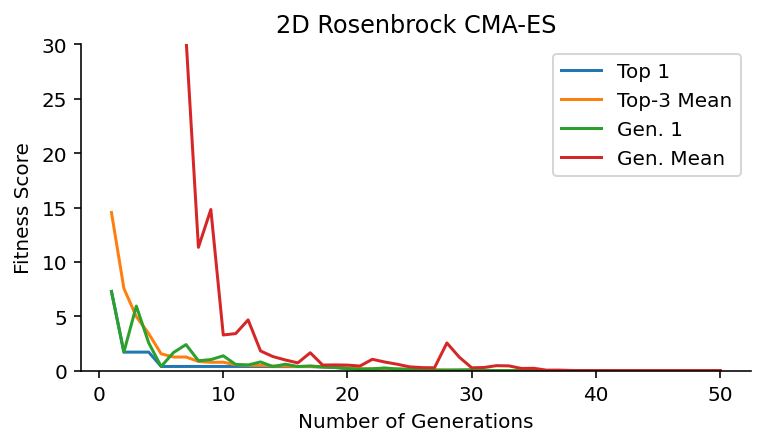

In [6]:
state = strategy.initialize(rng, es_params)
for i in range(num_gens):
    rng, rng_ask = jax.random.split(rng)
    # Ask for a set candidates
    x, state = strategy.ask(rng_ask, state, es_params)
    # Evaluate the candidates
    fitness = evaluator.rollout(rng, x)
    # Update the strategy based on fitness
    state = strategy.tell(x, fitness, state, es_params)
    # Update the log with results
    log = es_logging.update(log, x, fitness)
    
es_logging.plot(log, "2D Rosenbrock CMA-ES", ylims=(0, 30))

## Simultaneous PyTree Evaluation with `evosax`'s `ParameterReshaper`

`evosax` supports the automatic reshaping of proposed flat vectors into Pytrees for smooth neural network fitness evaluations. The transformation is again JAX-composable (`jit`, `vmap`, etc.). Below you find an example for a flax-based multi-layer perceptron:

In [7]:
from flax import linen as nn


class MLP(nn.Module):
    """Simple ReLU MLP."""

    num_hidden_units: int
    num_hidden_layers: int
    num_output_units: int

    @nn.compact
    def __call__(self, x, rng):
        for l in range(self.num_hidden_layers):
            x = nn.Dense(features=self.num_hidden_units)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_output_units)(x)
        return jax.random.categorical(rng, x)
    

# Instantiate the model callables and get a placeholder pytree
network = MLP(64, 2, 2)
policy_params = network.init(rng, jnp.zeros(4,), rng)["params"]

In [8]:
from evosax.utils import ParameterReshaper

# Instantiate the reshape helper & get total number of parameters to reshape
param_reshaper = ParameterReshaper(policy_params)
param_reshaper.total_params

DeviceArray(4610, dtype=int32)

Now let's instantiate another evolution strategy (`Differential_ES`) and generate a set of generation members: 

In [9]:
from evosax import Differential_ES
strategy = Differential_ES(popsize=100, num_dims=param_reshaper.total_params)
state = strategy.initialize(rng, strategy.default_params)
x, state = strategy.ask(rng, state, strategy.default_params)
x.shape

(100, 4610)

As we can see this is simply an array with (#population members, #parameters) shape. In order to reshape this array into stacked pytrees, we can simply pass it to the reshaper:

In [10]:
net_params = param_reshaper.reshape(x)
net_params.keys(), net_params['Dense_0']['kernel'].shape

(dict_keys(['Dense_0', 'Dense_1', 'Dense_2']), (100, 4, 64))

If you now want to map over the population member axis, you can do so with the of the `vmap_dict` (more about this later):

In [11]:
# Get dictionary to vectorize/parallelize rollouts with
param_reshaper.vmap_dict

{'Dense_0': {'bias': 0, 'kernel': 0},
 'Dense_1': {'bias': 0, 'kernel': 0},
 'Dense_2': {'bias': 0, 'kernel': 0}}

## Fitness Shaping with `evosax`'s `FitnessShaper`

By default `evosax` will minimize the objective. If you want to instead maximize it (as you commonly do with RL returns) or want to apply any other common ES fitness shaping, you can use the `FitnessShaper`:

In [12]:
from evosax import FitnessShaper
fit_shaper = FitnessShaper(centered_rank=True, w_decay=0.01, maximize=True)

x = jnp.array([[1.0], [2.0], [3.0]])
fit = jnp.array([0.0, 1.0, 2.0])
fit_shaper.apply(x, fit)

DeviceArray([ 0.49, -0.04, -0.59], dtype=float32)

## ARS on CartPole Task

`evosax` also comes with a simple fitness evaluation helper for a JAX-based version of Cartpole:

In [13]:
from evosax.problems import GymFitness

evaluator = GymFitness("Cartpole-v1", num_env_steps=200)
evaluator.set_apply_fn(network.apply)

You can then make use of the `vmap_dict` in order to vectorize the rollouts along the population axis:

In [14]:
rollout = jax.jit(jax.vmap(evaluator.rollout, in_axes=(None, param_reshaper.vmap_dict)))

In [15]:
from evosax import Augmented_RS

strategy = Augmented_RS(popsize=100,
                        num_dims=param_reshaper.total_params,
                        elite_ratio=0.1, opt_name="sgd")

es_params = {
        "lrate_init": 0.01,  # Initial learning rate
        "lrate_decay": 0.999, # Multiplicative decay factor
        "lrate_limit": 0.001,  # Smallest possible lrate
        "momentum": 0.0,  # Momentum coefficient
        "sigma_init": 0.02,  # Initial scale of isotropic Gaussian noise
        "sigma_decay": 0.999,  # Multiplicative decay factor
        "sigma_limit": 0.01,  # Smallest possible scale
        "init_min": -0.1,  # Range of parameter archive initialization - Min
        "init_max": 0.1,  # Range of parameter archive initialization - Max
        "clip_min": -10,  # Range of parameter proposals - Min
        "clip_max": 10  # Range of parameter proposals - Max
}

Generation:  0 Generation:  22.85
Generation:  20 Generation:  29.6
Generation:  40 Generation:  34.75
Generation:  60 Generation:  34.75
Generation:  80 Generation:  35.850002
Generation:  100 Generation:  50.05
Generation:  120 Generation:  53.5
Generation:  140 Generation:  81.85
Generation:  160 Generation:  110.1
Generation:  180 Generation:  167.35
Generation:  200 Generation:  198.05
Generation:  220 Generation:  200.0
Generation:  240 Generation:  200.0


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'CartPole Augmented Random Search'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

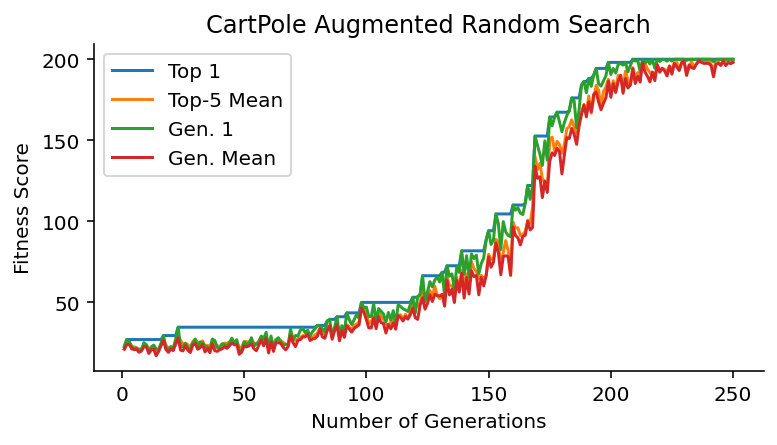

In [16]:
num_generations = 250
num_rollouts = 20
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()
fit_shaper = FitnessShaper(maximize=True)

state = strategy.initialize(rng, es_params)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state, es_params)
    reshaped_params = param_reshaper.reshape(x)
    batch_rng = jax.random.split(rng_eval, num_rollouts)
    fitness = rollout(batch_rng, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state, es_params)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Generation: ", -state["best_fitness"])
    #break
        
es_logging.plot(log, "CartPole Augmented Random Search")